# Preprocessing Part2  Jupiter Notebook: Extracting data from our csv and preparing it for the machine learning model
This is the second  preprocessing notebook. This notebook deals with processing the csv generated by the first notebook (preprocessed_data.csv) script,adds a new column called "Average Score" that displays the average score per each review and finally removes the "date column" as that is unneeded for this machine learning project.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [3]:

#first let's take a look at a general trend in the average score of reviews over time:
df=pd.read_csv("preprocessed_data.csv")

#convert the dates into datetime:
df["Dates"]= pd.to_datetime(df["Dates"])

In [4]:
df.head()

,Unnamed: 0,Dates,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews,Average Score
0,0,2022-11-15,Moved back to the UK end of August and got Vir...,1.0,1.0,1.0,1.0,1.00
1,1,2022-11-14,"A truly attrocious service, both in terms of b...",1.0,1.0,1.0,1.0,1.00
2,2,2022-11-13,They make it as hard as they can for you to ca...,1.0,1.0,2.0,2.0,1.50
3,3,2022-11-11,Pay for the 350Mbps package but only ever mana...,1.0,1.0,3.0,2.0,1.75
4,4,2022-11-11,The worst customer service:\r-The bots ask irr...,1.0,1.0,3.0,2.0,1.75


Visualise the data over time to see if date is an important feature or not (I suspespect not)

Text(0.5, 1.0, 'Average Scores of Virgin Media Reviews from 07/06/2018 to 15/11/2022')

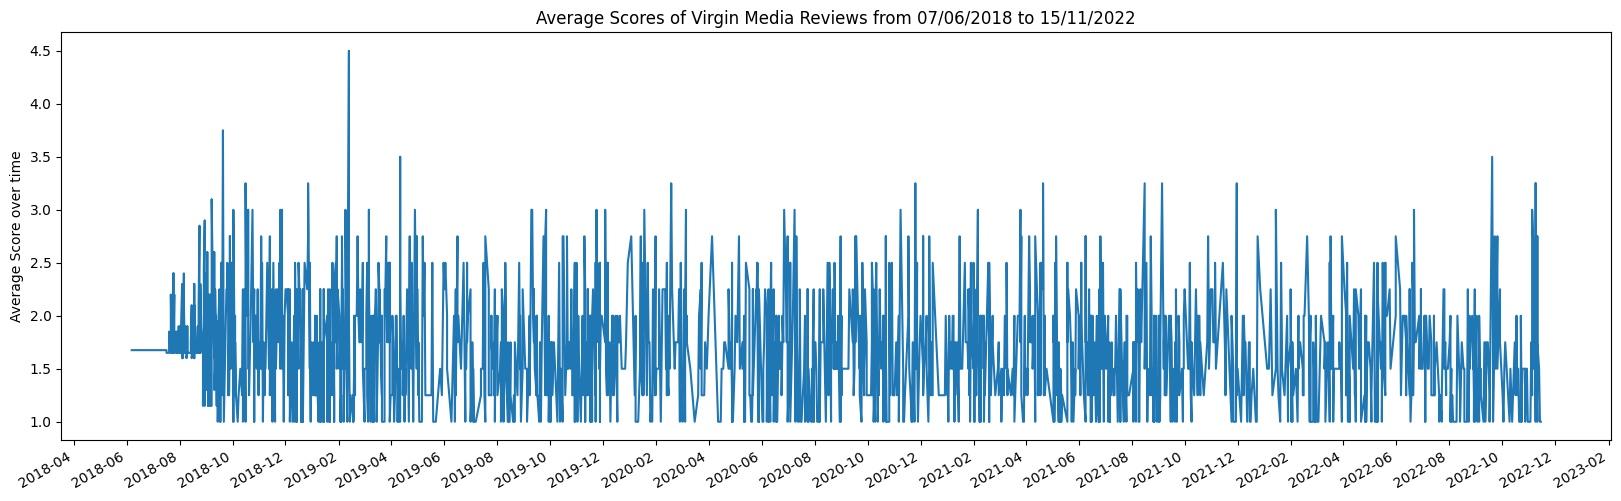

In [5]:
y_scores=np.array(df["Average Score"])
fig, ax=plt.subplots(figsize=(20, 6))
sixth_year_locator = mdates.MonthLocator(interval=2)
year_month_formatter = mdates.DateFormatter("%Y-%m") # four digits for year, two for month

ax.xaxis.set_major_locator(sixth_year_locator)
ax.xaxis.set_major_formatter(year_month_formatter) 
ax.plot(df["Dates"], df["Average Score"])
fig.autofmt_xdate()
# beautify the x-labels

ax.set_ylabel('Average Score over time')
ax.set_title("Average Scores of Company Reviews from 07/06/2018 to 15/11/2022", fontdict=None, loc='center')

In [6]:
df.head()

,Unnamed: 0,Dates,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews,Average Score
0,0,2022-11-15,Moved back to the UK end of August and got Vir...,1.0,1.0,1.0,1.0,1.00
1,1,2022-11-14,"A truly attrocious service, both in terms of b...",1.0,1.0,1.0,1.0,1.00
2,2,2022-11-13,They make it as hard as they can for you to ca...,1.0,1.0,2.0,2.0,1.50
3,3,2022-11-11,Pay for the 350Mbps package but only ever mana...,1.0,1.0,3.0,2.0,1.75
4,4,2022-11-11,The worst customer service:\r-The bots ask irr...,1.0,1.0,3.0,2.0,1.75


The  Average score does not seem to be directly related to time. It fluctuates periodically through out the years but overall it does not seem to be directly related to the average score of the reviews.. Thus we can safely drop this feature.

In [7]:
df.drop(["Dates", "Unnamed: 0"], axis=1, inplace=True)

In [8]:
df.head()

,Comments,Customer Service,Satisfaction Reviews,Speed Reviews,Reliability Reviews,Average Score
0,Moved back to the UK end of August and got Vir...,1.0,1.0,1.0,1.0,1.00
1,"A truly attrocious service, both in terms of b...",1.0,1.0,1.0,1.0,1.00
2,They make it as hard as they can for you to ca...,1.0,1.0,2.0,2.0,1.50
3,Pay for the 350Mbps package but only ever mana...,1.0,1.0,3.0,2.0,1.75
4,The worst customer service:\r-The bots ask irr...,1.0,1.0,3.0,2.0,1.75


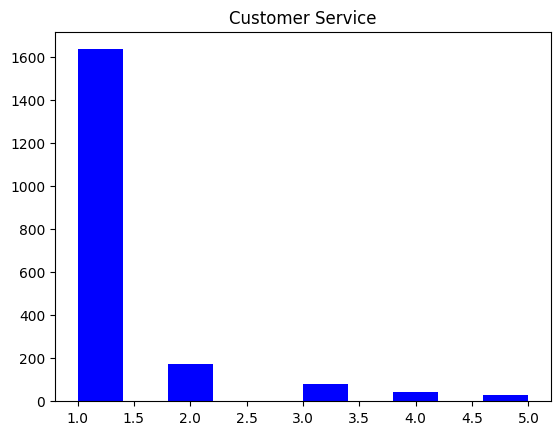

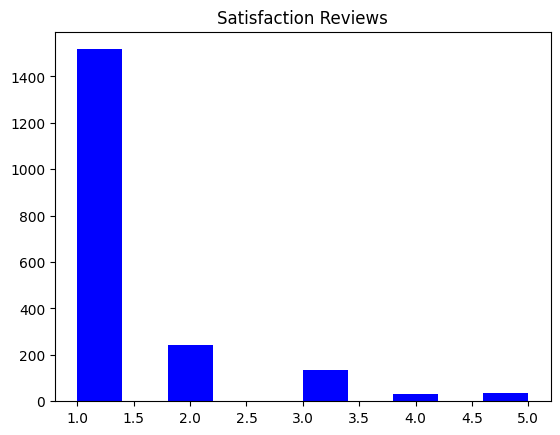

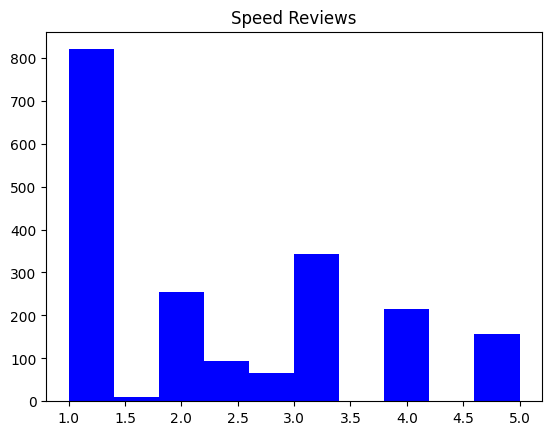

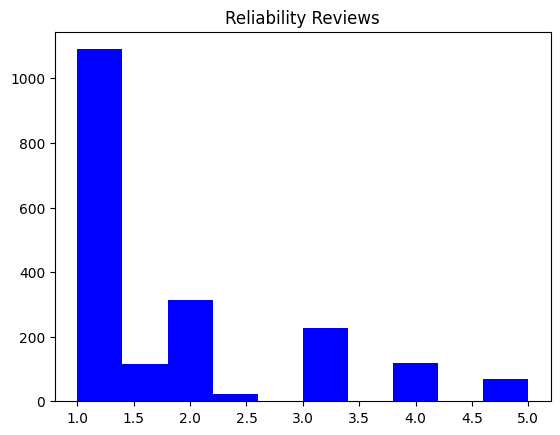

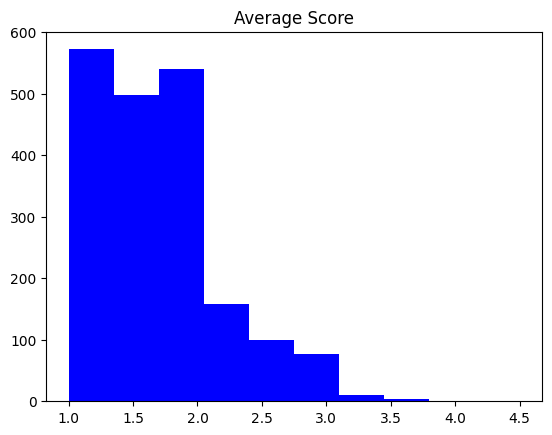

In [19]:
columns=list(df.columns)
for column in columns[1:]:
    plt.hist(df[column], color="blue")
    plt.title(column)
    plt.show() 

The histograms show that the majority of reviewers consider the service to be overall unsatisfactory as the majority of the reviews give it a less than satisfactory review.



This can indicate that the majority fo the text comments will be negative. So se will have a model that could get very good at predicting a bad review.

This is indicative that the company needs to improve its service towards customers (particularly its customer service, as that will influence the satisfaction reviews and reliability reviews (given that a customer service that is more responsive to customer queries and problems will result in a more satisfied clientele that will in turn perceive the company as more reliable))

However it must be said that teh majority of people that leave reviews ona  websites do so because they are unhappy (people like to rant and complain, fewer people like to praise a service) thus we can have a potentially unrepresented part of the clientele that is happy with the Company


In any case, for our next part of the data processing, we are going to keep the average score column as that gives usa  good idea of the average review rating and drop the rest of the review score columns.

We will use the comment column to try and predict the value of teh average score column.

In [22]:
df.drop(list(df.columns)[1:5], axis=1, inplace=True)


In [23]:
df.head()

,Comments,Average Score
0,Moved back to the UK end of August and got Vir...,1.00
1,"A truly attrocious service, both in terms of b...",1.00
2,They make it as hard as they can for you to ca...,1.50
3,Pay for the 350Mbps package but only ever mana...,1.75
4,The worst customer service:\r-The bots ask irr...,1.75


We are going to build a classifier model. For that we need to put teh average scores into one of 5 classes one for each star rating: 1,2,3,4,5 so that each time that a comment is fed into a model, the model decides if it is a review that it is a 5 start review, a 4 one, a 3 one, a 2 one or a 1 star one.

To do this we are going to round each float in the Average Score review to the nearest integer:

In [26]:
df['Average Score']=df['Average Score'].round()